In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import xarray as xr
import contextily as ctx
import shapely
import pint_xarray

In [ ]:
# Reset index to access the date column
events_by_site = pd.read_csv('../../data/classified_data/ros_events_by_site.csv')

# Extract the year from the date column
events_by_site['year'] = pd.to_datetime(events_by_site['date']).dt.year

# Group by site and year, and calculate the sum of rain on snow events
ros_sum_by_year = events_by_site.groupby(['site', 'year'])['ROS'].sum()

# Drop the year 2024 from the index since we don't have a lot of data from it
ros_sum_by_year = ros_sum_by_year.drop(index=2024, level='year').sort_index(level='year')

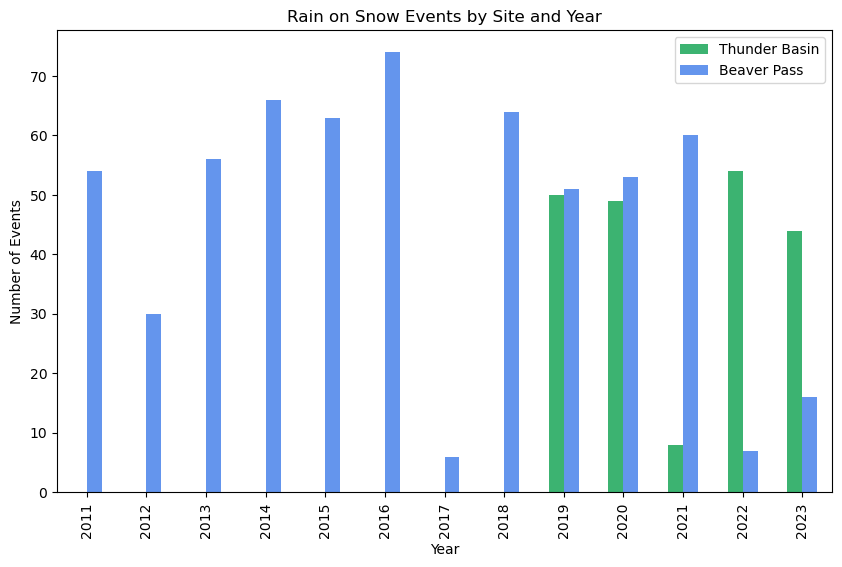

In [78]:
ros_sum_by_year.unstack(level=0).plot(
    kind='bar',
    figsize=(10, 6),
    title='Rain on Snow Events by Site and Year',
    xlabel='Year',
    ylabel='Number of Events',
    color=['mediumseagreen', 'cornflowerblue']
)
plt.legend(['Thunder Basin', 'Beaver Pass'])

In [79]:
from scipy.stats import linregress
import numpy as np

# Lets look at Trends
# Calculate the trend for each site
# Prepare a dictionary to store results
trend_results = {}

# Loop through each site
for site, group in ros_sum_by_year.unstack(level=0).items():
    # Drop NaN values
    group = group.dropna()
    years = group.index.values
    ros_values = group.values

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(years, ros_values)
    linear_trend = {'type': 'linear', 'slope': slope, 'intercept': intercept, 'r_squared': r_value**2}

    # Quadratic regression
    quadratic_coeffs = np.polyfit(years, ros_values, 2)
    quadratic_trend = {'type': 'quadratic', 'coefficients': quadratic_coeffs}

    # Store results
    trend_results[site] = {'linear': linear_trend, 'quadratic': quadratic_trend}

# Display the results
trend_results

{'817:WA:SNTL': {'linear': {'type': 'linear',
   'slope': np.float64(-0.7000000000000001),
   'intercept': np.float64(1455.7),
   'r_squared': np.float64(0.0034702549575070826)},
  'quadratic': {'type': 'quadratic',
   'coefficients': array([ 4.92857144e+00, -1.99219857e+04,  2.01319051e+07])}},
 '990:WA:SNTL': {'linear': {'type': 'linear',
   'slope': np.float64(-2.197802197802198),
   'intercept': np.float64(4479.120879120879),
   'r_squared': np.float64(0.13508949679162446)},
  'quadratic': {'type': 'quadratic',
   'coefficients': array([-7.16283716e-01,  2.88729071e+03, -2.90956001e+06])}}}

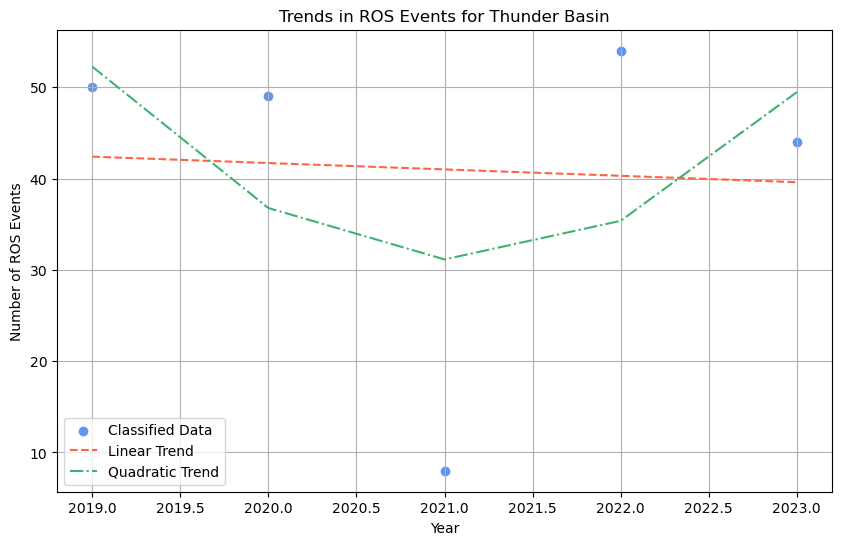

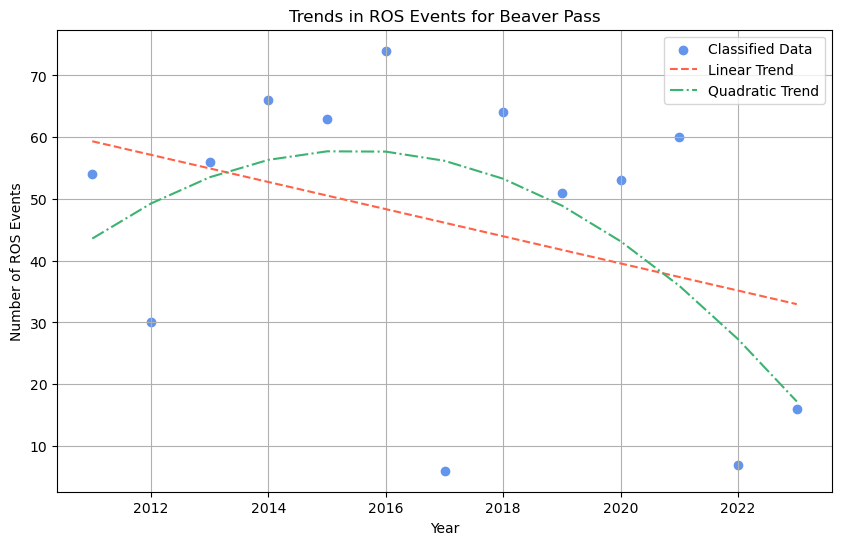

In [ ]:
site_map = {'817:WA:SNTL': 'Thunder Basin', '990:WA:SNTL': 'Beaver Pass'}
# Plot the trends for each site
for site, trends in trend_results.items():
    
    # Undo group, get year and number of events
    group = ros_sum_by_year.unstack(level=0)[site].dropna()
    years = group.index.values
    ros_values = group.values

    # Generate linear trend line
    linear_trend = trends['linear']
    linear_fit = linear_trend['slope'] * years + linear_trend['intercept']

    # Generate quadratic trend line
    quadratic_trend = trends['quadratic']
    quadratic_fit = (
        quadratic_trend['coefficients'][0] * years**2 +
        quadratic_trend['coefficients'][1] * years +
        quadratic_trend['coefficients'][2]
    )

    # Plot the data and trends
    plt.figure(figsize=(10, 6))
    plt.scatter(years, ros_values, label='Classified Data', color='cornflowerblue')
    plt.plot(years, linear_fit, label='Linear Trend', color='tomato', linestyle='--')
    plt.plot(years, quadratic_fit, label='Quadratic Trend', color='mediumseagreen', linestyle='-.')
    plt.title(f'Trends in ROS Events for {site_map[site]}')
    plt.xlabel('Year')
    plt.ylabel('Number of ROS Events')
    plt.legend()
    plt.grid(True)
    plt.show()